# <font color='blue'>Introduction to Wavelets</font>

---

<img src="images/cea_logo.png" width="100" align="right">


> Author: **Samuel Farrens**

> Year: **2016**

> Version: **1.0**

> Email: **[samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)**

> Web: **[CosmoStat Website](http://www.cosmostat.org/)**


## <font color='blue'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Windowed Fourier Transform](#Windowed-Fourier-Transform)
 * [Discrete Fourier Transform](#Discrete-Fourier-Transform)
 * [Gabor Transform](#Gabor-Transform)
1. [Wavelets](#Wavelets)
 * [Multiresolution Analysis](#Multiresolution-Analysis)
 * [Wavelet Types](#Wavelet-Types)
 * [Wavelet Transforms](#Wavelet-Transforms)
 * [Denoising Example](#Denoising-Example)

## <font color='blue'>Set-Up</font>

---

Here we will import a couple of packages that we will need throughout the notebook.

In [2]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Import some tools from scipy.
from scipy import fftpack, signal

# Import time package.
import time

# SOME USEFUL FUNCTIONS

# Function to calculate an orthonormal descrete cosine transform.
def fft(signal):

    return fftpack.fft(signal)

# Function to calculate an orthonormal descrete cosine transform.
def ifft(signal):

    return fftpack.ifft(signal)

# Function to calculate the median absolute deviation.
def sigma_mad(signal):
    
    return 1.4826 * np.median(np.abs(signal - np.median(signal)))

# Function for performing hard thresholding.
def hard_thresh(signal, threshold):
    
    return signal * (np.abs(signal) >= threshold)

# Function to hide plot axes.
def hide_axes(axis):
    
    axis.xaxis.set_ticklabels([])
    axis.yaxis.set_ticklabels([])

## <font color='blue'>Introduction</font>

---

Wavelets are a class functions that are localised in both time and frequency (or space and scale). In this notebook we will explore some of the basic properties of wavelets and how they compare to other time-frequency analysis techniques.


## <font color='blue'>Windowed Fourier Transform</font>

---

Most signals can be decomposed into a sum of sine and cosine waves.

### <font color='green'>Discrete Fourier Transform</font>

The Discrete Fourier Transform (DFT) can be represented as:

$$F[n] = \frac{1}{N} \sum_{k=0}^{N-1} f[k] e^{2\pi i kn/N}$$

where $N$ denotes the number of data points, and $n$ and $k$ represent the ordinals in the time and frequency domains respectively. The corresponding inverse function is:

$$f[k] = \sum_{n=0}^{N-1} F[n] e^{-2\pi i kn/N}$$

We can use this transform to extract frequency information from a given signal.

/usr/local/lib/python2.7/dist-packages/scipy/signal/waveforms.py:236: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if t == 'cutoff':  # compute cut_off point


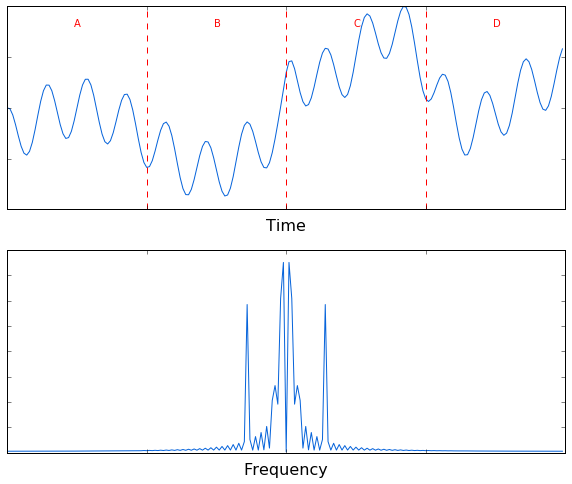

In [3]:
# Define the signal
n = np.linspace(-1, 1, 200, endpoint=False)
Fn  = np.cos(2 * np.pi * 7 * n) + signal.gausspulse(n - 0.4, fc=2) + np.sin(2 * np.pi * n) + np.tanh(2 * np.pi * 8 * n)
Fn /= max(abs(Fn))

# Get the Fourier transform of the signal
fk = np.abs(fftpack.fftshift(fft(Fn)))

# Display
ax1 = plt.subplot(211)
ax1.plot(n, Fn, '-', color='#0764DB')
ax1.plot([-0.5, -0.5], [-1, 1], 'r--')
ax1.plot([0.0, 0.0], [-1, 1], 'r--')
ax1.plot([0.5, 0.5], [-1, 1], 'r--')
plt.text(-0.76, 0.8, 'A', color='red')
plt.text(-0.26, 0.8, 'B', color='red')
plt.text(0.24, 0.8, 'C', color='red')
plt.text(0.74, 0.8, 'D', color='red')
ax1.set_xlabel('Time', fontsize=16)
hide_axes(ax1)
ax2 = plt.subplot(212)
ax2.plot(n, fk, '-', color='#0764DB')
ax2.set_xlabel('Frequency', fontsize=16)
hide_axes(ax2)
plt.show()

In doing so, however, we lose all of the time information. We can try instead looking at the frequency information contained within smaller time intervals.

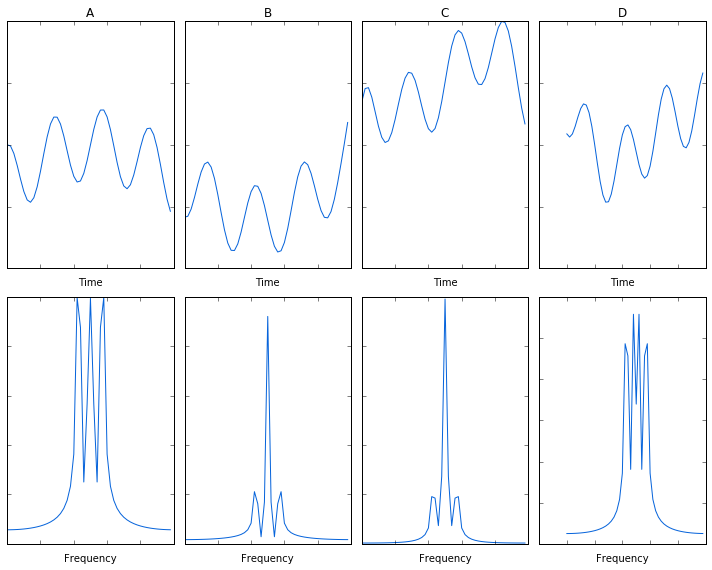

In [4]:
# Slice the signal into four pieces
slice_size = n.size / 4
slices = [slice(i * slice_size, (i + 1) * slice_size) for i in range(4)]
titles = ('A', 'B', 'C', 'D')

# Display
for i in range(len(slices)):
    fk_slice = np.abs(fftpack.fftshift(fft(Fn[slices[i]])))
    ax = plt.subplot(2, 4, i + 1)
    ax.plot(n[slices[i]], Fn[slices[i]], '-', color='#0764DB')
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time')
    ax.set_title(titles[i])
    hide_axes(ax)
    ax = plt.subplot(2, 4, i + 5)
    ax.plot(n[slices[i]], fk_slice, '-', color='#0764DB')
    ax.set_xlabel('Frequency')
    hide_axes(ax)
plt.tight_layout()
plt.show()

Notice that we can identify different frequencies of the signal contained within the time intervals, but what happens if we make the windows smaller?

### <font color='green'>Uncertainty Principle</font>

The **Heisenberg–Gabor limit**, 

$$\Delta t \Delta \omega \geq \frac{1}{2},$$

an interpretation of the uncertainty principle, shows that it is not possible to simultaneously sharply localize a signal in both the time domain and frequency domain.

In other words we will always need to make a trade-off between time information and frequency information, but is the best way to preserve as much of both as possible?

### <font color='green'>Gabor Transform</font>

The Gabor transform or Short Time Fourier Transform (STFT) can be represented as:

$$f[m, k] = \sum_{n=0}^{N-1} F[n] g[n - m] e^{-2\pi i kn/N}$$

where $g$ is a filter localised at $m$. Effectively this performs a Fourier transform of the signal within a filter that is centred at $m$. 

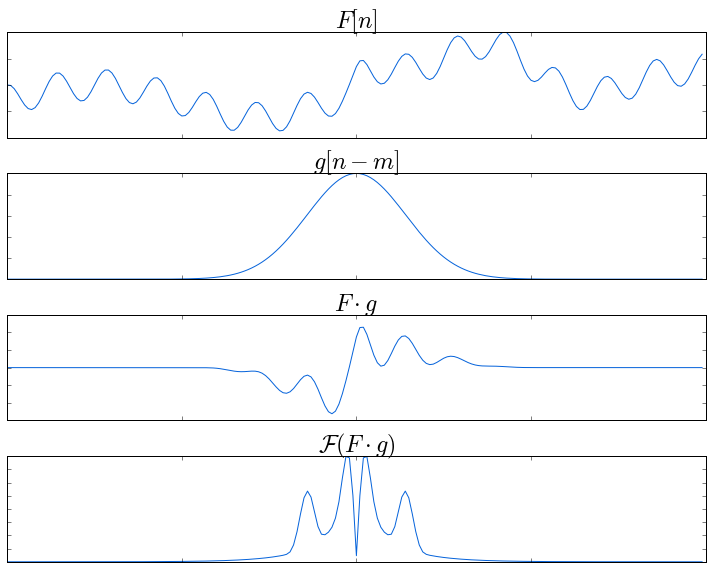

In [5]:
# Define a Gaussian filter.
def get_filter(m, w):

    return np.exp(-w * (n - m) ** 2)

# Set filter width.
width = 25

# Set filter position.
pos = 0.0

# Get localised filter.
g = get_filter(pos, width)

# Filter the signal.
Fg = Fn * g

# Get frequencies of filtered signal.
Fg_fft = np.abs(np.fft.fftshift(fft(Fg)))

# Display.
fig, ax = plt.subplots(4, 1)
ax[0].plot(n, Fn, '-', color='#0764DB')
ax[0].set_title('$F[n]$', fontsize=24)
ax[1].plot(n, g, '-', color='#0764DB')
ax[1].set_title('$g[n-m]$', fontsize=24)
ax[2].plot(n, Fg, '-', color='#0764DB')
ax[2].set_title('$F \cdot g$', fontsize=24)
ax[3].plot(n, Fg_fft, '-', color='#0764DB')
ax[3].set_title('$\mathcal{F}(F \cdot g)$', fontsize=24)
[hide_axes(i) for i in ax]
plt.tight_layout()
plt.show()


Try adjusting the filter width and position ($-1\leq m\leq 1$) and see what happens.

Now, to try to preserve some frequency and time information simultaneously we will slide the filter across the whole signal and store the frequencies at a set of time intervals.

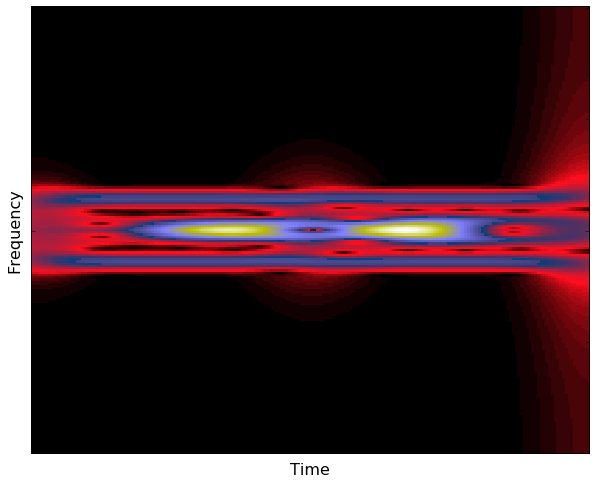

In [6]:
# Set a range of time intervals.
intervals = np.arange(-1, 1, 0.01)

# Get the FFT of the filtered signal at each interval.
w = []
for m in intervals:
    w.append(np.abs(np.fft.fftshift(fft(Fn * get_filter(m, width)))))
w = np.array(w).T

# Display
fig, ax = plt.subplots(1, 1)
ax.imshow(w, aspect='auto', interpolation='nearest', cmap='gist_stern')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
hide_axes(ax)
plt.show()

Try changing the filter width to see what happens.

While we retain information in both time and frequency domains we also lose resolution. When the window is small we have good time localisation but we can only capture high frequencies. On the other hand, when the window is large we can capture lower frequencies but we have very poor time localisation.

## <font color='blue'>Wavelets</font>

---

### <font color='green'>Multiresolution Analysis</font>

One way we can improve upon the Gabor method is using *Multiresolution Analysis (MRA)*. Rather than choosing a fixed window size that will be more localised in either the time or frequency domain, we can instead do the following:

* Start with a small window and extract the highest frequency content of the signal with very good time localisation.
* Then remove these frequencies from the signal.
* Then by enlarging the window by a small amount we can pick out the highest remaining frequencies, which will be lower than those removed, with slighly worse time localisation.
* This process can be continued until the widow contains the entire signal which will only retain the lowest frequencies with virtually no time localisation.

### <font color='green'>Wavelet Types</font>

The wavelet function is often represented as follows:

$$\psi_{a,b}(t) = \frac{1}{\sqrt{a}} \psi \Bigg(\frac{t-b}{a} \Bigg)$$

where $a$ defines the wavelet scale and $b$ the shift. $\psi$ is known as the *Mother Wavelet* which must posses certain properties (see *e.g.* [Wikipedia](https://en.wikipedia.org/wiki/Wavelet#Mother_wavelet) for more details). Many different wavelets exist, but we will only discuss a few basic ones.

A couple of essential properties we want any given wavelet to have are the following:

* $\int_{-\infty}^\infty\psi(t)dt = 0$ (*i.e.* equal positive and negative area under the curve)
* $\|\psi(t)\|_2^2 = 1$
* [Compact support](http://mathworld.wolfram.com/CompactSupport.html) (*i.e.* signal does not last forever)


**Haar Wavelet**

The Haar wavelet (1910) is a basic step function and is defined as follows:

$$\psi(t) = \begin{cases}1 & 0 \leq t \leq \frac{1}{2} \\ -1 & \frac{1}{2} \leq t \leq 1 \\ 0 & \text{otherwise}\end{cases}$$


In [8]:
# Function to define Haar wavelet.
def haar_wt(t):

    t = np.array([t])
    x = np.zeros(t.size)
    x += np.array((0.0 <= t)[0] * (t < 0.5)[0])
    x -= np.array((0.5 <= t)[0] * (t < 1.0)[0])
    return x

**Mexican Hat Wavelet**

The Mexican Hat (or Ricker) wavelet  is defined as follows:

$$\psi(t) = \frac{2}{\sqrt{3\sigma}\pi^{\frac{1}{4}}}\Bigg(1-\frac{t^2}{\sigma^2}\Bigg)e^{-\frac{t^2}{2\sigma^2}}$$


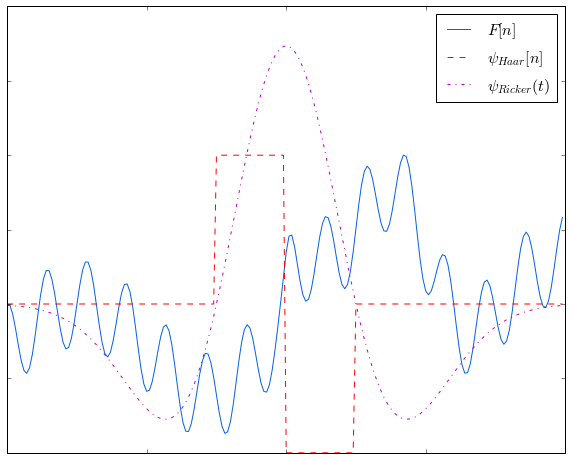

In [9]:
# Function to define mexican hat wavelet.
def mex_hat_wt(t, sigma=1.0):

    return (2.0 * np.pi ** -0.25 * (3.0 * sigma) ** -0.5 *
            (1 - (t / sigma) ** 2) * np.exp(-t ** 2 / (2.0 * sigma ** 2)))

# Display
fig, ax = plt.subplots(1, 1)
ax.plot(n, Fn, '-', color='#0764DB', label=r'$F[n]$')
ax.plot(n, haar_wt(2 * n + 0.5), 'r--', label=r'$\psi_{Haar}[n]$')
ax.plot(n, mex_hat_wt(n, 0.25), 'm-.', label=r'$\psi_{Ricker}(t)$')
hide_axes(ax)
plt.legend(fontsize=16)
plt.show()

In general one aims to use the wavelet most suited to the problem at hand.

### <font color='green'>Wavelet Transforms</font>

The **Continuous Wavelet Transform (CWT)** is used to decompose a signal into wavelets and can be defined as follows:

$$F_{\omega}(a, b) = \frac{1}{|a|^{0.5}}\int_{-\infty}^\infty f(t)\bar{\psi}\Bigg(\frac{t-b}{a}\Bigg)dt$$

We can use this to transform our signal into the wavelet domain using the Mexican Hat wavelet.

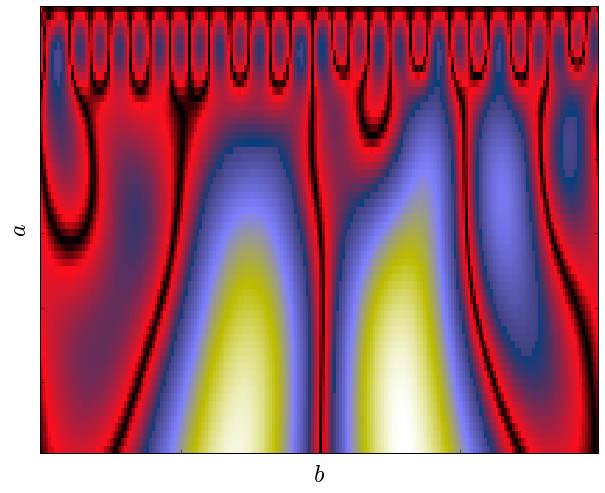

In [10]:
# Function to get wavelet scales
def get_scales(a_min, a_max):
    
    J = 12.0 * np.log2(a_max / a_min)
    del_a = (a_max - a_min) / (J - 1)
    return a_min + del_a * np.arange(J)

# Function to perform continuous wavelet transform
def cwt(data, wavelet, scales):
    
    x_ft = np.fft.fft(data)
    t = np.arange(data.size) - (data.size - 1.0) / 2
    out = []
    for scale in scales:
        w_ft = np.fft.fft(wavelet(t / scale) * scale ** -0.5)
        out.append(np.fft.fftshift(np.fft.ifft(w_ft * x_ft)))
    return np.abs(out)

# Set wavelet scales
scales = get_scales(1, 31)

# Wavetlet transform the signal
y = cwt(Fn, mex_hat_wt, scales)

# Display
fig, ax = plt.subplots(1, 1)
ax.imshow(y, aspect='auto', interpolation='nearest', cmap='gist_stern')
ax.set_xlabel('$b$', fontsize=24)
ax.set_ylabel('$a$', fontsize=24)
hide_axes(ax)
plt.show()

As you can see we are able to preserve detailed information regarding the scale and translation of the signal.

The **Discrete Wavelet Transform (DWT)** uses a discrete set of wavelet scales and translations that removes certain redundancies introduced in the CWT.

$$c_{j+1, l} = \sum h_{k-2l}c_{j,k} = (\bar{h}*c_j)_{2l}$$
$$w_{j+1, l} = \sum g_{k-2l}c_{j,k} = (\bar{g}*c_j)_{2l}$$

This corresponds to consecutively convolving the signal with high and low pass filters with a downsampling at each level (read more [here](https://en.wikipedia.org/wiki/Discrete_wavelet_transform)). 

<img src="images/dwt.png" width="800">

The **Undecimated Wavelet Transform (UWT)** (also called the Stationary Wavelet Transform) removes the downsampling factor to compensate for the translation-invariance in the DWT at the cost of added redundancy (read more [here](https://en.wikipedia.org/wiki/Stationary_wavelet_transform)).   

<img src="images/uwt.png" width="600">

Other specialised wavelet transforms exist such as the **Starlet** (or Isotropic Undecimated Wavelet Transform) which is particularly well suited to astrophysical images (read more [here](http://jstarck.free.fr/Chapter_Starlet2011.pdf)).


### <font color='green'>Denoising Example</font>

Let's look at an example of a galaxy image.

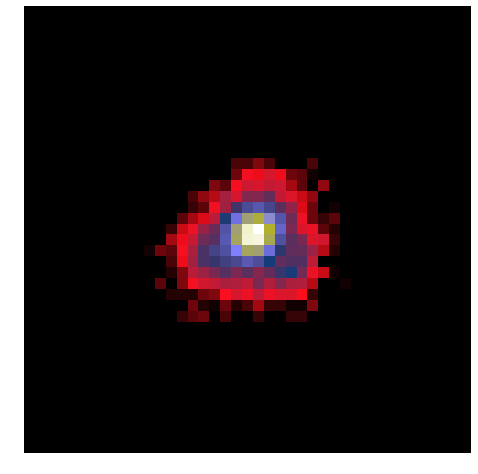

In [11]:
from wavelet import *

# Load galaxy image
image = np.load('images/galaxy_example.npy')

# Display
plt.imshow(image, cmap='gist_stern', interpolation='nearest')
plt.axis('off')
plt.show()

We can decompose this image into undecimated isotropic wavelet components that show features at different scales. We do this using some [iSap](http://www.cosmostat.org/software/isap/) software.

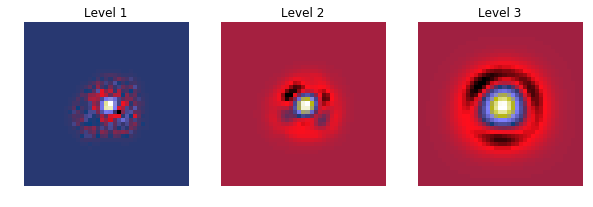

In [12]:
# Get wavelet filters
filters = get_mr_filters(image.shape)

# Wavelet transform image
wave_coef = filter_convolve(image, filters)

# Display
for i, wave in enumerate(wave_coef):
    plt.subplot(1, 3, i + 1)
    plt.imshow(wave, cmap='gist_stern', interpolation='nearest')
    plt.title('Level ' + str(i + 1))
    plt.axis('off')
plt.show()

Now, if we add noise to the image it becomes much harder to identify.

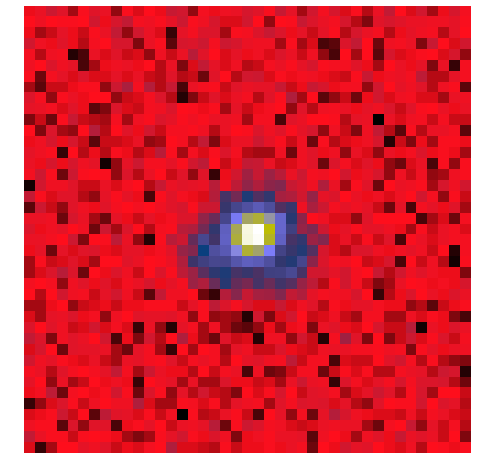

In [13]:
# Set noise level
sigma = 0.05

# Add noise to image
image_noisy = image + sigma * np.random.randn(*image.shape)

# Display
plt.imshow(image_noisy, cmap='gist_stern', interpolation='nearest')
plt.axis('off')
plt.show()

We can try to filter out this noise in the wavelet domain.

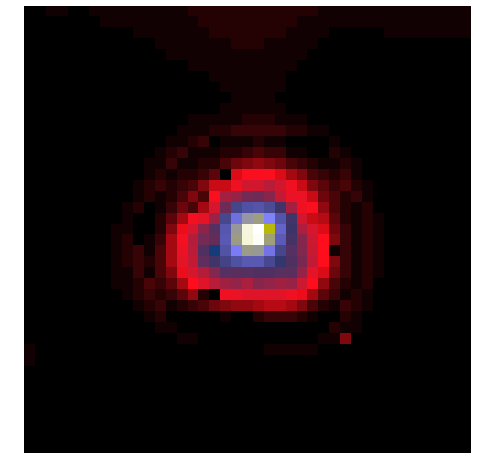

In [15]:
# Set the threshold factor
n_sigma = 4

# Denoise image 
image_rec = call_mr_filter(image_noisy, opt=['-t', '1', '-s', str(n_sigma)])

# Display
plt.imshow(image_rec, cmap='gist_stern', interpolation='nearest')
plt.axis('off')
plt.show()

A large fraction of the noise is removed, but not all of it. Try increasing the threshold factor to see if you can do better. 